In [102]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

from torch import nn
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

In [60]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [62]:
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [118]:
X = torch.linspace(0, 10, 100).reshape(-1, 1)
true_weight = 2.0
true_bias = 1.0
true_sigma = 1.0
y = true_weight * X.squeeze() + true_bias + torch.randn(100) * true_sigma

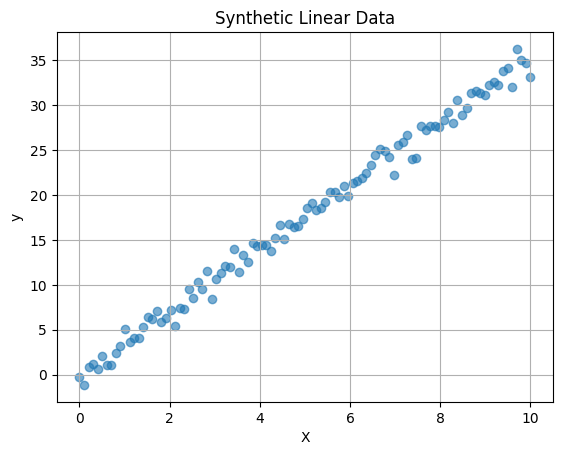

In [50]:
plt.scatter(X.numpy(), y.numpy(), alpha=0.6)
plt.title("Synthetic Linear Data")
plt.xlabel("X")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [51]:
pyro.clear_param_store()

In [63]:
"""def model(X, y=None):
    weight = pyro.sample("weight", dist.Normal(0., 10.))
    bias = pyro.sample("bias", dist.Normal(0., 10.))
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))
    mean = weight * X.squeeze() + bias
    with pyro.plate("data", X.shape[0]):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)"""


'def model(X, y=None):\n    weight = pyro.sample("weight", dist.Normal(0., 10.))\n    bias = pyro.sample("bias", dist.Normal(0., 10.))\n    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))\n    mean = weight * X.squeeze() + bias\n    with pyro.plate("data", X.shape[0]):\n        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)'

In [76]:
linear_reg_model = PyroModule[nn.Linear](1, 1)

In [65]:
"""def guide(X, y=None):
    weight_loc = pyro.param("weight_loc", torch.tensor(1.0))
    weight_scale = pyro.param("weight_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    bias_loc = pyro.param("bias_loc", torch.tensor(0.0))
    bias_scale = pyro.param("bias_scale", torch.tensor(1.0), constraint=dist.constraints.positive)
    sigma_loc = pyro.param("sigma_loc", torch.tensor(1.0), constraint=dist.constraints.positive)
    
    pyro.sample("weight", dist.Normal(weight_loc, weight_scale))
    pyro.sample("bias", dist.Normal(bias_loc, bias_scale))
    pyro.sample("sigma", dist.HalfCauchy(sigma_loc))"""

'def guide(X, y=None):\n    weight_loc = pyro.param("weight_loc", torch.tensor(1.0))\n    weight_scale = pyro.param("weight_scale", torch.tensor(1.0), constraint=dist.constraints.positive)\n    bias_loc = pyro.param("bias_loc", torch.tensor(0.0))\n    bias_scale = pyro.param("bias_scale", torch.tensor(1.0), constraint=dist.constraints.positive)\n    sigma_loc = pyro.param("sigma_loc", torch.tensor(1.0), constraint=dist.constraints.positive)\n    \n    pyro.sample("weight", dist.Normal(weight_loc, weight_scale))\n    pyro.sample("bias", dist.Normal(bias_loc, bias_scale))\n    pyro.sample("sigma", dist.HalfCauchy(sigma_loc))'

In [66]:
"""svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())

n_steps = 3000
for step in range(n_steps):
    loss = svi.step(X, y)
    if step % 500 == 0:
        print(f"[step {step}] loss = {loss:.2f}")

print("Learned weight:", pyro.param("weight_loc").item())
print("Learned bias:", pyro.param("bias_loc").item())
print("Learned sigma:", pyro.param("sigma_loc").item())"""

'svi = SVI(model, guide, Adam({"lr": 0.01}), loss=Trace_ELBO())\n\nn_steps = 3000\nfor step in range(n_steps):\n    loss = svi.step(X, y)\n    if step % 500 == 0:\n        print(f"[step {step}] loss = {loss:.2f}")\n\nprint("Learned weight:", pyro.param("weight_loc").item())\nprint("Learned bias:", pyro.param("bias_loc").item())\nprint("Learned sigma:", pyro.param("sigma_loc").item())'

In [77]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

In [78]:
def train():
    # run the model forward on the data
    y_pred = linear_reg_model(X).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

In [79]:
for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 1439.3982
[iteration 0100] loss: 213.2126
[iteration 0150] loss: 188.7934
[iteration 0200] loss: 166.1574
[iteration 0250] loss: 146.0254
[iteration 0300] loss: 129.1807
[iteration 0350] loss: 115.7775
[iteration 0400] loss: 105.5716
[iteration 0450] loss: 98.1055
[iteration 0500] loss: 92.8441
[iteration 0550] loss: 89.2662
[iteration 0600] loss: 86.9155
[iteration 0650] loss: 85.4220
[iteration 0700] loss: 84.5039
[iteration 0750] loss: 83.9577
[iteration 0800] loss: 83.6431
[iteration 0850] loss: 83.4678
[iteration 0900] loss: 83.3731
[iteration 0950] loss: 83.3237
[iteration 1000] loss: 83.2987
[iteration 1050] loss: 83.2865
[iteration 1100] loss: 83.2807
[iteration 1150] loss: 83.2781
[iteration 1200] loss: 83.2769
[iteration 1250] loss: 83.2764
[iteration 1300] loss: 83.2762
[iteration 1350] loss: 83.2761
[iteration 1400] loss: 83.2761
[iteration 1450] loss: 83.2761
[iteration 1500] loss: 83.2761
Learned parameters:
weight [[3.535526]]
bias [-0.06519686]


In [86]:
list(linear_reg_model.named_parameters())

[('weight',
  Parameter containing:
  tensor([[3.5355]], requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([-0.0652], requires_grad=True))]

In [87]:
linear_reg_model(X).detach().cpu().numpy()

array([[-0.06519686],
       [ 0.29192695],
       [ 0.6490508 ],
       [ 1.0061747 ],
       [ 1.3632984 ],
       [ 1.7204223 ],
       [ 2.0775464 ],
       [ 2.4346702 ],
       [ 2.7917938 ],
       [ 3.1489177 ],
       [ 3.5060415 ],
       [ 3.8631654 ],
       [ 4.220289  ],
       [ 4.577413  ],
       [ 4.934537  ],
       [ 5.291661  ],
       [ 5.648784  ],
       [ 6.005908  ],
       [ 6.363032  ],
       [ 6.7201557 ],
       [ 7.0772796 ],
       [ 7.4344034 ],
       [ 7.7915273 ],
       [ 8.148651  ],
       [ 8.505775  ],
       [ 8.862899  ],
       [ 9.220023  ],
       [ 9.577147  ],
       [ 9.934271  ],
       [10.291394  ],
       [10.648519  ],
       [11.005642  ],
       [11.362765  ],
       [11.71989   ],
       [12.077013  ],
       [12.434137  ],
       [12.791261  ],
       [13.148385  ],
       [13.505508  ],
       [13.862632  ],
       [14.219756  ],
       [14.57688   ],
       [14.934004  ],
       [15.291128  ],
       [15.648252  ],
       [16

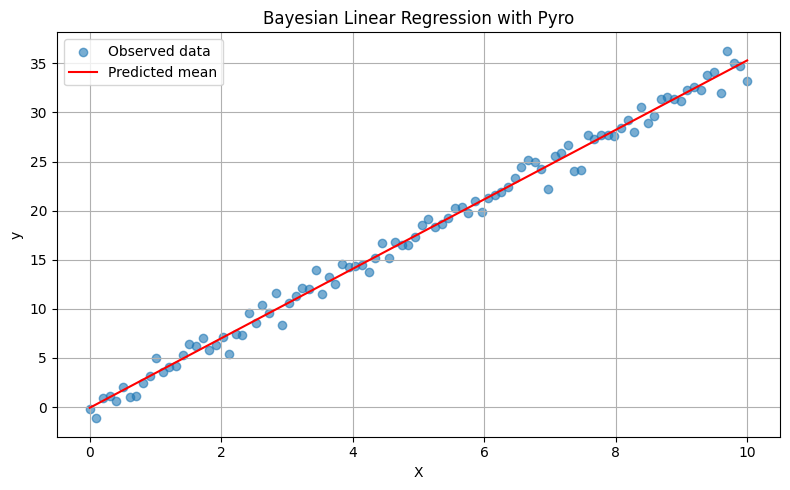

In [90]:
y_pred = linear_reg_model(X).detach().cpu().numpy()
X_np = X.numpy()
y_np = y.numpy()

plt.figure(figsize=(8, 5))
plt.scatter(X_np, y_np, alpha=0.6, label="Observed data")
plt.plot(X_np, y_pred, color='red', label="Predicted mean")
#plt.fill_between(X_sorted, y_pred - 2*sigma, y_pred + 2*sigma,
#                 color='red', alpha=0.3, label="±2σ uncertainty")
plt.xlabel("X")
plt.ylabel("y")
plt.title("Bayesian Linear Regression with Pyro")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 10.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [97]:
model = BayesianRegression(1, 1)
guide = AutoDiagonalNormal(model)

In [99]:
adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [100]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X, y)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(X)))



[iteration 0001] loss: 2135.8260
[iteration 0101] loss: 222.7099
[iteration 0201] loss: 51.3205
[iteration 0301] loss: 21.0505
[iteration 0401] loss: 11.9541
[iteration 0501] loss: 9.4206
[iteration 0601] loss: 8.4604
[iteration 0701] loss: 7.2394
[iteration 0801] loss: 6.2457
[iteration 0901] loss: 5.9716
[iteration 1001] loss: 5.2196
[iteration 1101] loss: 4.6988
[iteration 1201] loss: 4.2871
[iteration 1301] loss: 3.8671
[iteration 1401] loss: 3.6636


In [101]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.8611, 0.8662, 0.8711]),
 'linear.weight': tensor([[[3.0151]],
 
         [[3.0488]],
 
         [[3.0825]]]),
 'linear.bias': tensor([[3.0257],
         [3.0740],
         [3.1224]])}

In [103]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(X)
pred_summary = summary(samples)

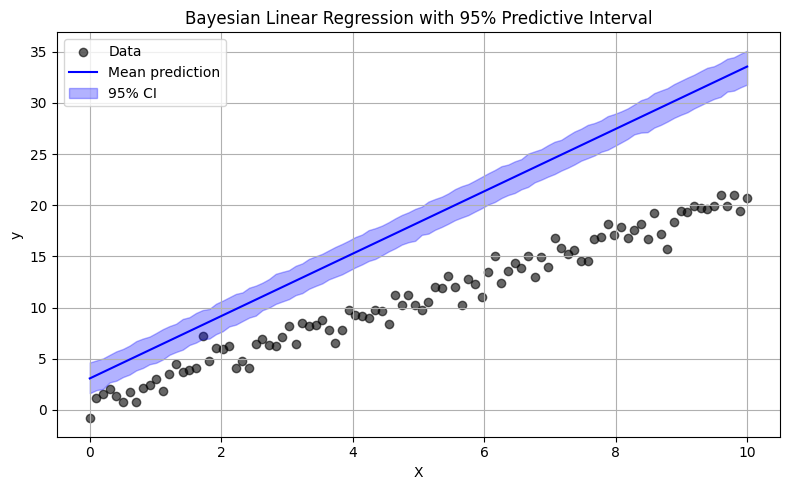

In [132]:
X_plot = X.squeeze().detach().cpu().numpy()
y_data = y.detach().cpu().numpy()

# Get posterior predictive summaries
mu = pred_summary["_RETURN"]            # [num_samples, N]
y_pred = pred_summary["obs"]            # [num_samples, N]

# Compute statistics
mu_mean = mu["mean"].detach().cpu().numpy()
y_low = pred_summary["obs"]["5%"].detach().cpu().numpy()
#y_med = pred_summary["obs"]["50%"].detach().cpu().numpy()
y_high = pred_summary["obs"]["95%"].detach().cpu().numpy()

# Sort X for clean line plotting
sort_idx = X_plot.argsort()
X_sorted = X_plot[sort_idx]
mu_sorted = mu_mean[sort_idx]
y_low_sorted = y_low[sort_idx]
y_high_sorted = y_high[sort_idx]

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X_plot, y_data, color="black", label="Data", alpha=0.6)
plt.plot(X_sorted, mu_mean, color="blue", label="Mean prediction")
plt.fill_between(X_sorted, y_low_sorted, y_high_sorted, color="blue", alpha=0.3, label="95% CI")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.title("Bayesian Linear Regression with 95% Predictive Interval")
plt.grid(True)
plt.tight_layout()
plt.show()